In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from itertools import product
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from utils import concat2d, uniform_sample_frames

camera = "bottom" # or "top"
serial_numbers = {
    "bottom": "17475185",
    "top": "17475187",
}
# adjust based on spacing of the corridors
# for example these values mean that the 1st corridor spans from y=64 to y=64 + 320,
# 2nd corridor from y=64 + 320 to y=64 + 2*320, etc.
corridor_height = 320
n_corridors = 6
y0 = 64

data_dir = Path("/mnt/upramdya/data/TL/ball_pushing/")
paths = [i.as_posix() for i in sorted(data_dir.glob(f"*/*{serial_numbers[camera]}.mp4"))]
paths

['/mnt/upramdya/data/TL/ball_pushing/ExR1(EB)/20250714-150800-17475185.mp4',
 '/mnt/upramdya/data/TL/ball_pushing/ExR1(EB)/20250714-162807-17475185.mp4',
 '/mnt/upramdya/data/TL/ball_pushing/ExR1(EB)/20250715-155558-17475185.mp4',
 '/mnt/upramdya/data/TL/ball_pushing/ExR1(EB)/20250722-155742-17475185.mp4',
 '/mnt/upramdya/data/TL/ball_pushing/ExR1(EB)/20250731-170855-17475185.mp4',
 '/mnt/upramdya/data/TL/ball_pushing/GH146/20250731-143638-17475185.mp4',
 '/mnt/upramdya/data/TL/ball_pushing/LC10-2/20250724-155238-17475185.mp4',
 '/mnt/upramdya/data/TL/ball_pushing/LC10-2/20250724-170424-17475185.mp4',
 '/mnt/upramdya/data/TL/ball_pushing/LC10-2/20250728-151522-17475185.mp4',
 '/mnt/upramdya/data/TL/ball_pushing/LC10-2/20250731-160045-17475185.mp4',
 '/mnt/upramdya/data/TL/ball_pushing/LH272/20250723-150839-17475185.mp4',
 '/mnt/upramdya/data/TL/ball_pushing/LH272/20250723-161847-17475185.mp4',
 '/mnt/upramdya/data/TL/ball_pushing/LH272/20250724-143039-17475185.mp4',
 '/mnt/upramdya/dat

(np.float64(-0.5), np.float64(1535.5), np.float64(799.5), np.float64(-0.5))

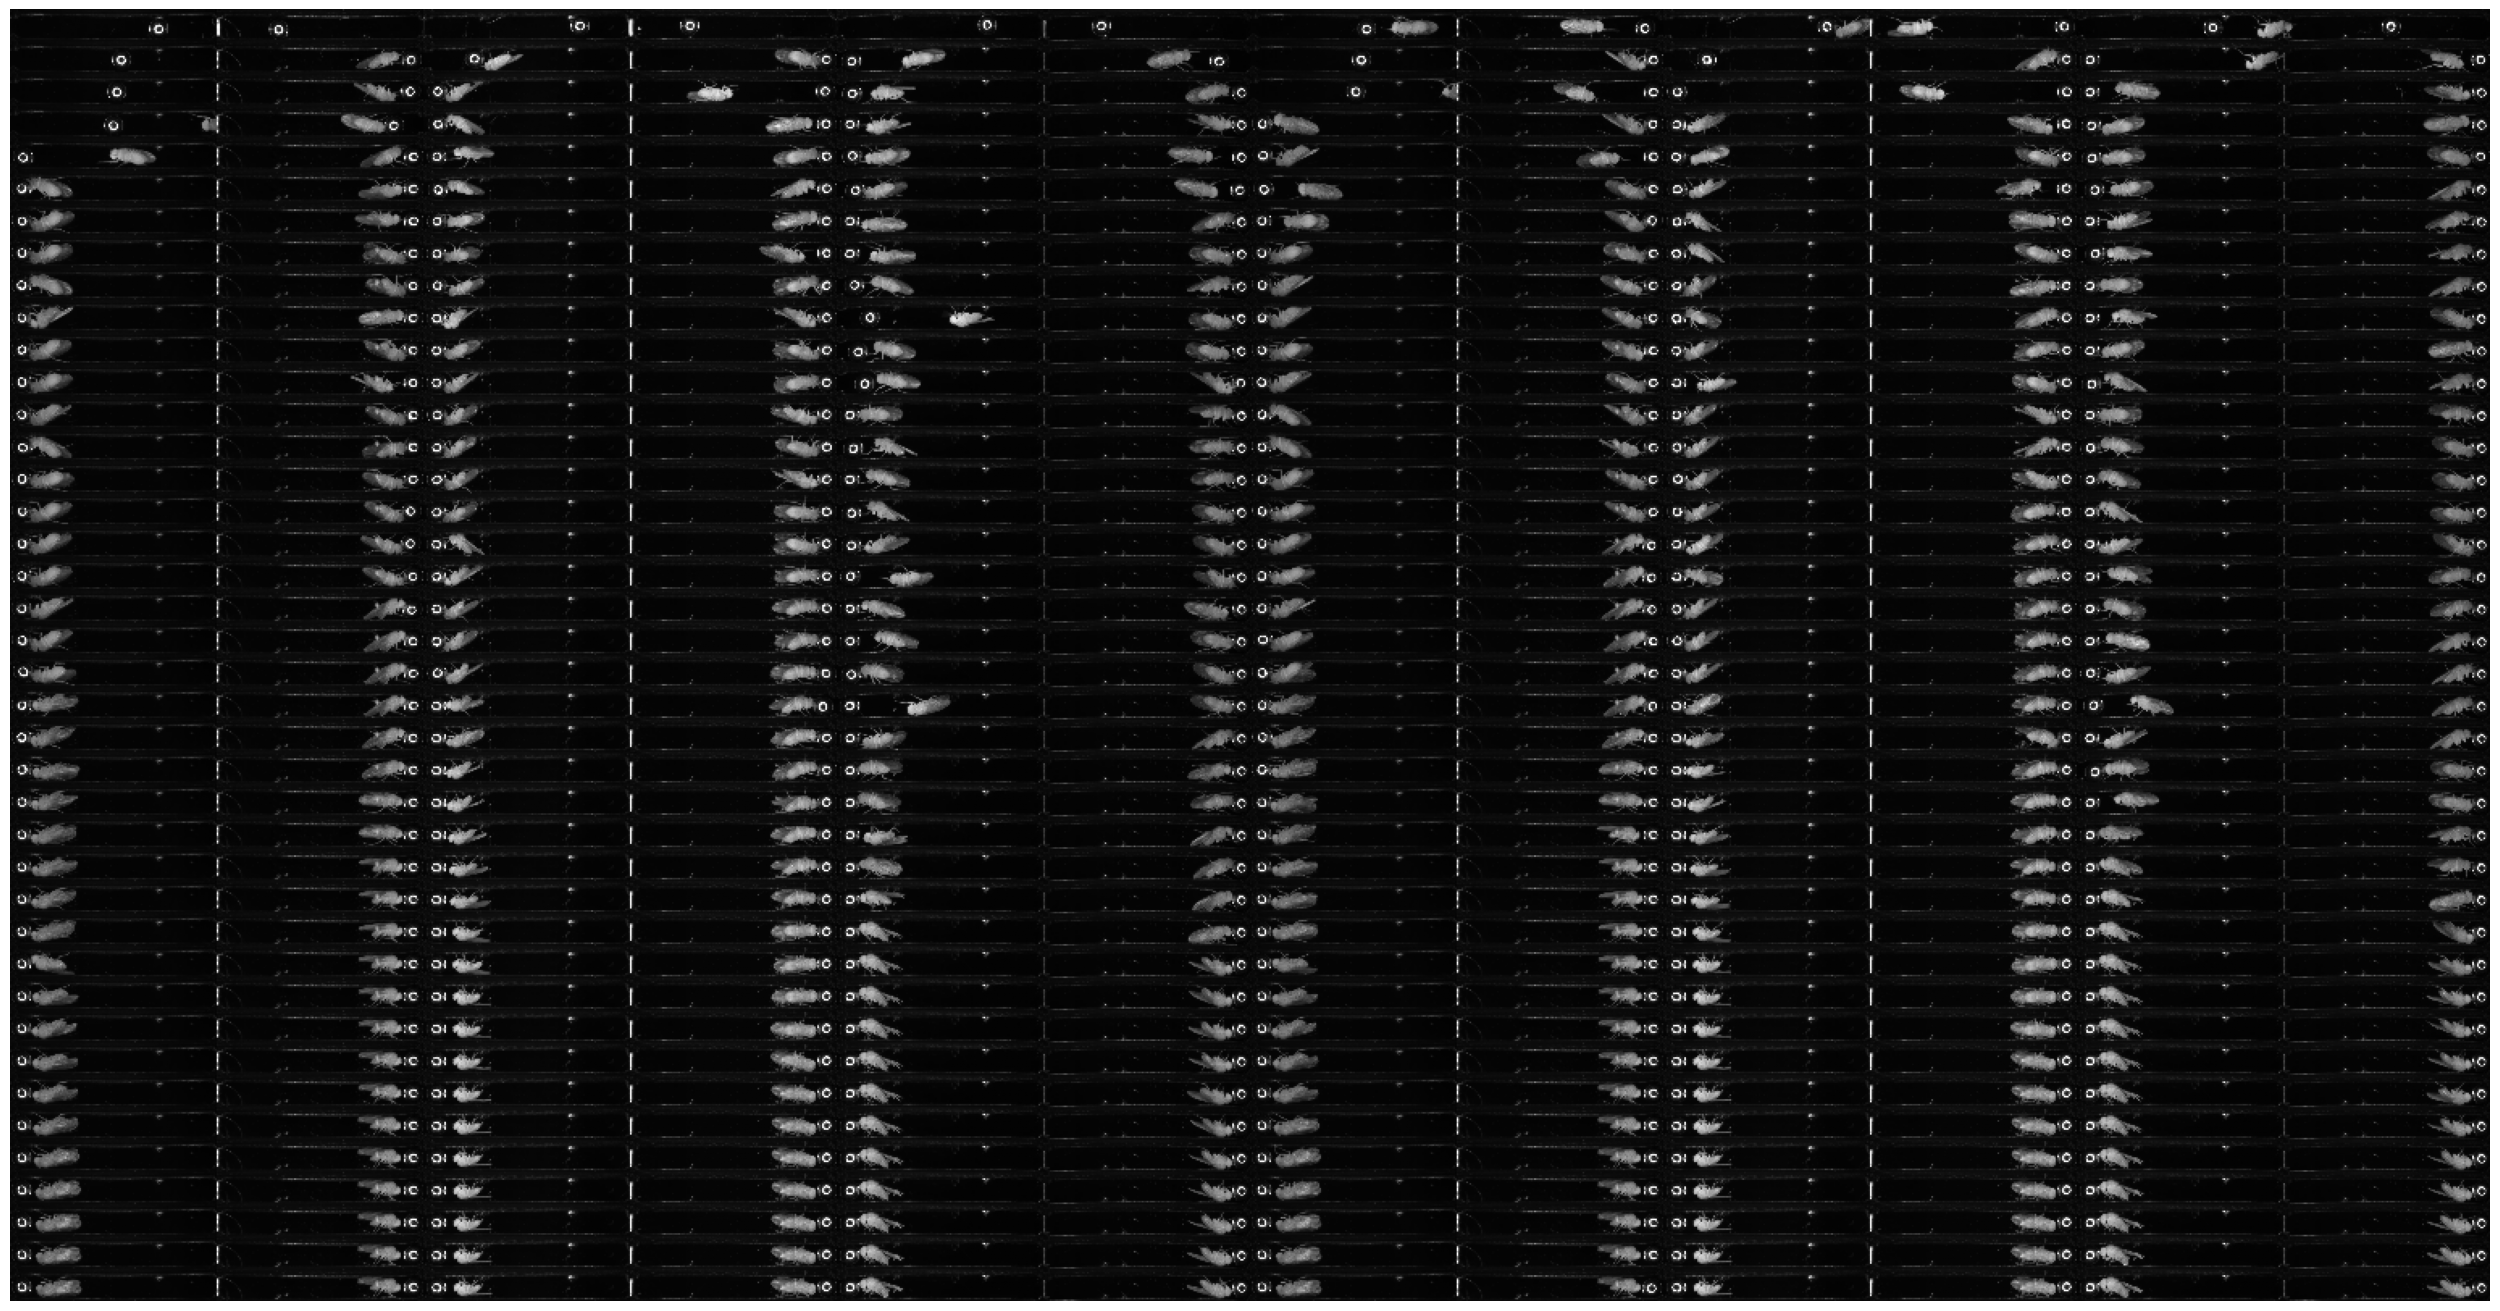

In [3]:
# sample frames and display them
path = paths[5]
n_frames = 80
frames = uniform_sample_frames(path, n_frames, y0, n_corridors, corridor_height)

fig, ax = plt.subplots(figsize=(32, 18))
ax.imshow(concat2d(frames[:, :, ::16, ::16].reshape((480, 20, 128)), 40, 12), cmap="gray")
ax.axis("off")

Creating new template


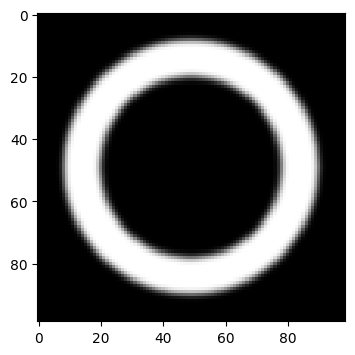

In [ ]:
# create template for ball detection
def get_ball_template(half_ksize, radius, thickness=10):
    template = np.zeros((half_ksize * 2 - 1,) * 2, dtype=np.uint8)
    cv2.circle(template, (half_ksize - 1,) * 2, radius, 255, thickness, lineType=cv2.LINE_AA)
    cv2.GaussianBlur(template, (5, 5), 0, dst=template)
    return template

template_path = f"data/ball_template_{camera}.png"
Path(template_path).parent.mkdir(exist_ok=True, parents=True)
half_ksize = 50
ksize = half_ksize * 2 - 1
radius = 35
thickness = 10

# if the template does not exist, create one by drawing a circle
if Path(template_path).exists():
    print(f"Loading template from {template_path}")
    template = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
else:
    print(f"Creating new template")
    template = get_ball_template(half_ksize, radius, thickness)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(template, cmap="gray")

In [5]:
# get ball positions using template matching
ball_positions = np.full((n_frames, n_corridors, 2), -1, dtype=np.int32)
ball_scores = np.full((n_frames, n_corridors), np.nan, dtype=np.float32)
it = list(product(range(n_frames), range(n_corridors)))

for i_frame, i_corridor in tqdm(it):
    score_map = cv2.matchTemplate(frames[i_frame, i_corridor], template, cv2.TM_CCOEFF_NORMED)
    ymax, xmax = np.unravel_index(np.argmax(score_map), score_map.shape)
    ball_positions[i_frame, i_corridor] = xmax, ymax
    ball_scores[i_frame, i_corridor] = score_map[ymax, xmax]

assert np.all(ball_positions >= 0)
ball_positions += (template.shape[1] // 2, template.shape[0] // 2)

100%|██████████| 480/480 [00:02<00:00, 195.64it/s]


In [6]:
# crop the ball images
ball_ims = []

for i_frame, i_corridor in tqdm(it):
    x, y = ball_positions[i_frame, i_corridor]
    ball_im = frames[i_frame, i_corridor, y - half_ksize + 1:y + half_ksize, x - half_ksize + 1:x + half_ksize]
    if ball_im.shape == (ksize,) * 2:
        ball_ims.append(ball_im)

ball_ims = np.array(ball_ims, dtype=np.uint8)

100%|██████████| 480/480 [00:00<00:00, 840612.08it/s]


(np.float64(-0.5), np.float64(2969.5), np.float64(1583.5), np.float64(-0.5))

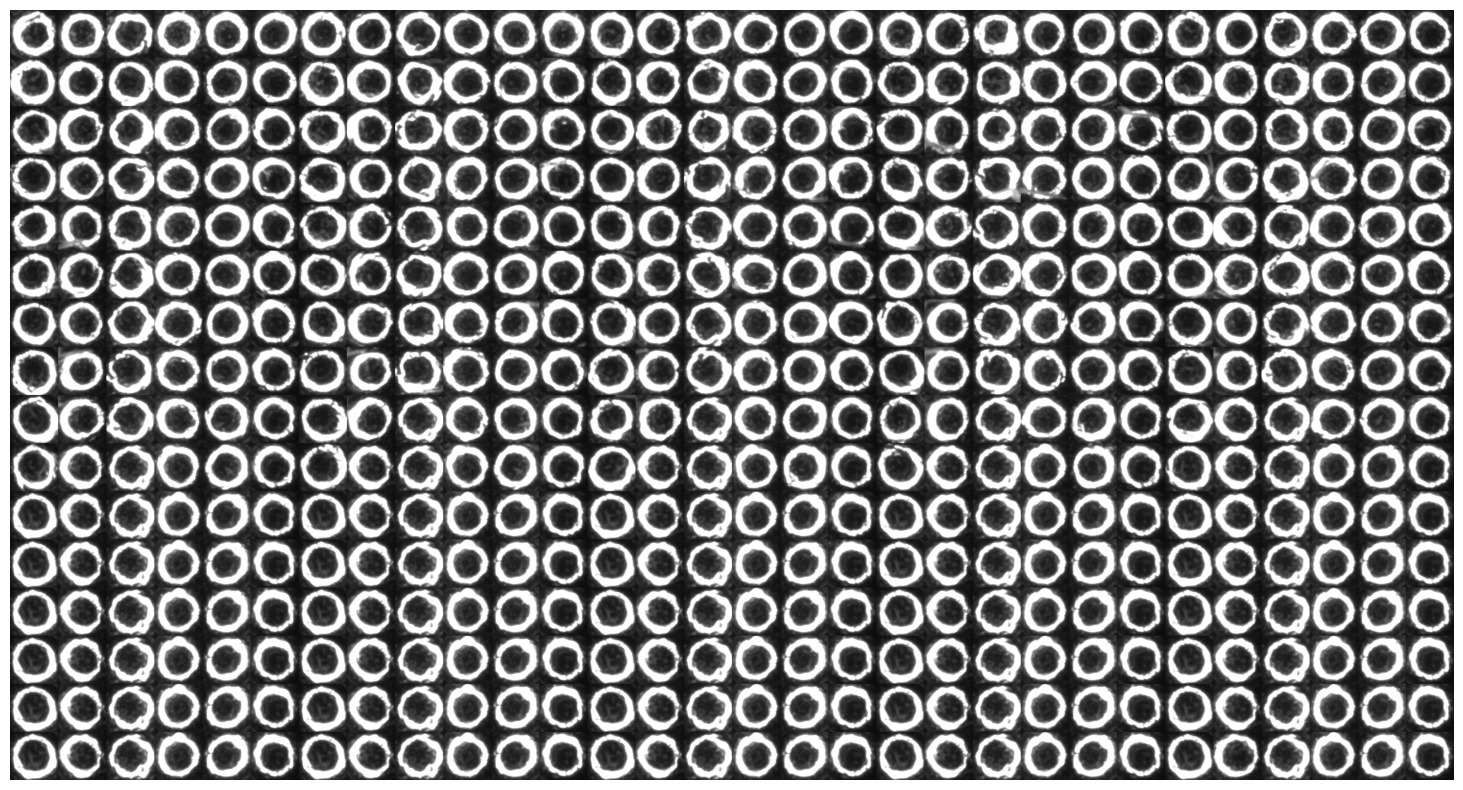

In [7]:
# adjust threshold until most of the images are balls
threshold = 0.5
ball_ims_rgb = np.stack((ball_ims,) * 3, axis=-1)
above_threshold = ball_scores.ravel() > threshold
ball_ims_rgb[~above_threshold, ..., 1:] = 0

# images below the threshold are shown in red
fig, ax = plt.subplots(figsize=(30, 10))
ax.imshow(concat2d(ball_ims_rgb, 16, 30))
ax.axis("off")

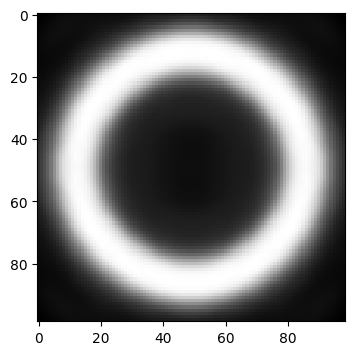

In [ ]:
# average the ball images
ball_mean = ball_ims[ball_scores.ravel() > threshold].mean(0)
# flip and average for symmetry
ball_mean = (ball_mean + ball_mean[::-1]) / 2
ball_mean = (ball_mean + ball_mean[:, ::-1]) / 2

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(ball_mean, cmap="gray")

In [ ]:
# optional: refine the template
cv2.imwrite(template_path, np.round(ball_mean).astype(np.uint8))